In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
sys.path.append('../../utils/')
from fig12code import *

,lake_id,dist_along_track_m,lon,lat,manual,surrf_2024,RTE_Sentinel2_red,RTE_Landsat8_red_pan,watta
0,1,1130.452313,67.255835,-72.99690,0.0,0.0,0.0,0.0,NaN
1,1,1129.325293,67.255839,-72.99689,0.0,0.0,0.0,0.0,NaN
2,1,1128.198708,67.255844,-72.99688,0.0,0.0,0.0,0.0,NaN
3,1,1127.072123,67.255849,-72.99687,0.0,0.0,0.0,0.0,NaN
4,1,1125.945538,67.255854,-72.99686,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
4616,4,202.459474,67.860690,-71.63765,0.0,0.0,0.0,0.0,NaN
4617,4,201.336417,67.860695,-71.63764,0.0,0.0,0.0,0.0,NaN
4618,4,200.213361,67.860699,-71.63763,0.0,0.0,0.0,0.0,NaN
4619,4,199.084667,67.860704,-71.63762,0.0,0.0,0.0,0.0,NaN


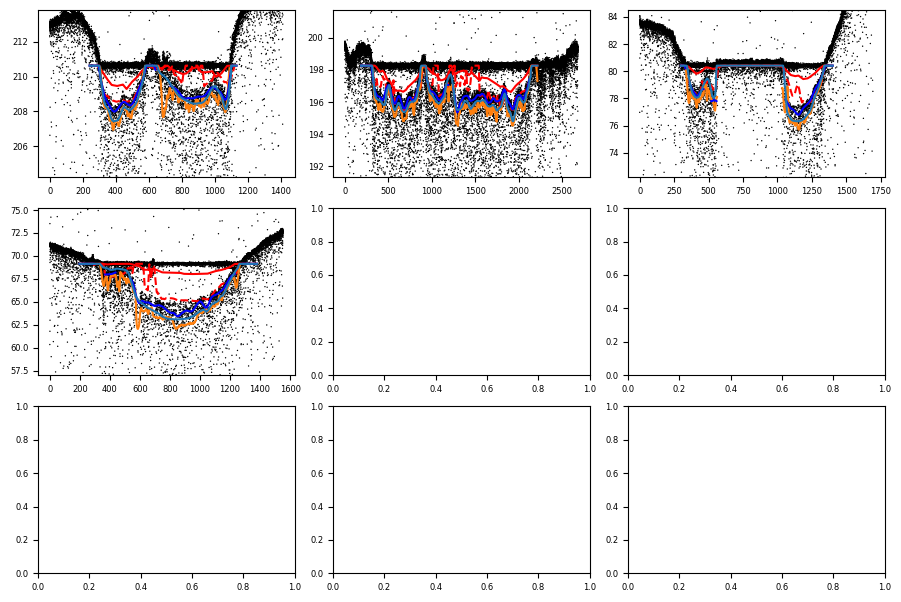

In [7]:
rename_cols = {'Unnamed: 0': 'lat', 
               'moussavi_pope': 'RTE_Landsat8_red_pan', 
               'spergel_kingslake': 'RTE_Sentinel2_red',
               'datta': 'watta',
               'pond': 'lake_id'
              }
dfm = pd.read_csv('raw/fricker_allCompiledDepthData.csv').rename(columns=rename_cols)

dfm['surrf_2024'] = np.nan # initialize column for surrf
dfm['lon'] = np.nan # initialize column for surrf
dfm['dist_along_track_m'] = np.nan # initialize column for surrf

ref_idx = 1.336
conf_threshold = 0.3

plt.rcParams.update({'font.size': 6})
fig, axs = plt.subplots(figsize=[9,6], nrows=3, ncols=3)
axs = axs.flatten()

for ilake in np.arange(1,5):
    
    selector = dfm.lake_id == ilake
    dfi = dfm[selector].copy()
    lk = dictobj(read_melt_lake_h5('lake_amery_fricker_%i.h5' % ilake))
    hsurf = lk.surface_elevation
    surf = np.ones_like(dfi.manual)*hsurf
    surf[dfi.manual==0] = np.nan
    df = lk.photon_data
    df.loc[df.h < hsurf, 'h'] = hsurf - (hsurf - df.loc[df.h < hsurf, 'h']) / ref_idx
    dfd = lk.depth_data.sort_values(by='lat')
    man_bed = hsurf - dfi.manual
    man_bed[dfi.manual == 0] = np.nan
    fit_bed = dfd.h_fit_bed.copy()
    fit_bed[fit_bed > hsurf] = np.nan
    fit_bed[(dfd.conf < conf_threshold)] = np.nan
    
    depth = dfd.depth.copy()
    depth[(dfd.conf < conf_threshold)] = np.nan
    depth_interp = np.interp(dfi.lat, dfd.lat, depth, left=np.nan, right=np.nan)
    dfm.loc[selector, 'surrf_2024'] = depth_interp

    # get the lat/lon/xatc
    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby('x10')[['xatc', 'lon', 'lat']].median().sort_values(by='lat').reset_index(drop=True)
    dfm.loc[selector, 'lon'] = np.interp(dfm[selector].lat, gt.lat, gt.lon)
    dfm.loc[selector, 'dist_along_track_m'] = np.interp(dfm[selector].lat, gt.lat, gt.xatc)

    ax = axs[ilake-1]
    dfinterp = dfm[dfm.lake_id == ilake]
    ax.scatter(df.xatc, df.h, s=1, color='k', edgecolors='none')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.manual, zorder=10)
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.RTE_Sentinel2_red, 'r-')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.RTE_Landsat8_red_pan, 'r--')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.watta)
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.surrf_2024, 'b-')
    ax.set_ylim((hsurf - 2*dfinterp.manual.max(), hsurf + dfinterp.manual.max()))

fig.tight_layout()
    
df_fricker = dfm[['lake_id', 'dist_along_track_m', 'lon', 'lat', 'manual', 'surrf_2024', 'RTE_Sentinel2_red', 'RTE_Landsat8_red_pan', 'watta']].copy()
to_correct = ['manual', 'RTE_Sentinel2_red', 'RTE_Landsat8_red_pan', 'watta']
df_fricker.loc[:,to_correct] = df_fricker.loc[:,to_correct] / ref_idx
display(df_fricker)
plt.close(fig)
display(fig)

df_fricker.to_csv('data_fricker_2021.csv', index=False)

,lake_id,dist_along_track_m,lon,lat,surrf_2024,manual,Z_green,Z_red,Z_corrected_dem
0,1,1306.5,-49.138228,67.080167,0.0,NaN,NaN,NaN,NaN
1,1,1301.5,-49.138216,67.080212,0.0,NaN,NaN,NaN,NaN
2,1,1296.5,-49.138203,67.080256,0.0,NaN,NaN,NaN,NaN
3,1,1291.5,-49.138190,67.080301,0.0,NaN,NaN,NaN,NaN
4,1,1286.5,-49.138177,67.080345,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1515,5,2049.5,-48.290592,67.536716,0.0,NaN,NaN,NaN,NaN
1516,5,2054.5,-48.290606,67.536761,0.0,NaN,NaN,NaN,NaN
1517,5,2059.5,-48.290619,67.536805,0.0,NaN,NaN,NaN,NaN
1518,5,2064.5,-48.290633,67.536850,0.0,NaN,NaN,NaN,NaN


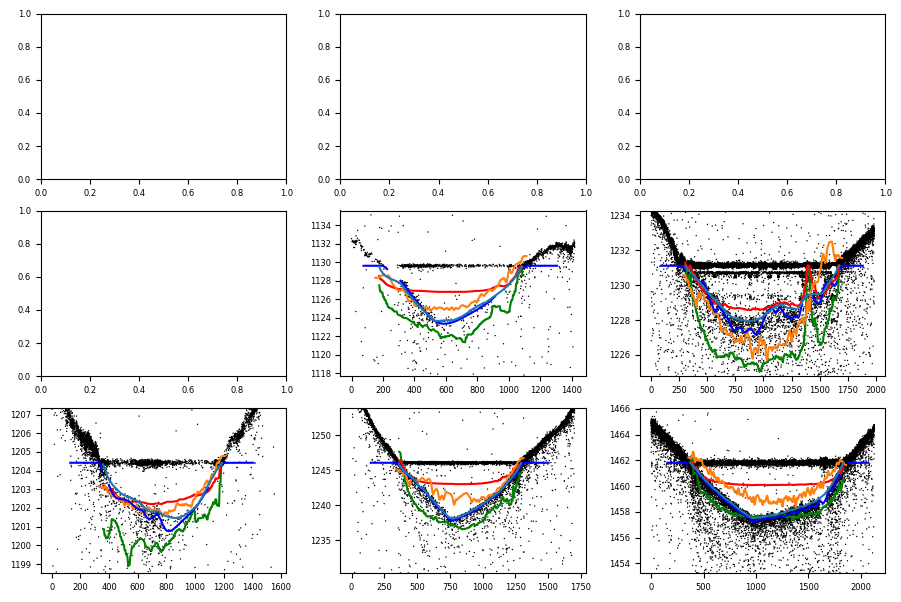

In [8]:
plt.rcParams.update({'font.size': 6})
fig, axs = plt.subplots(figsize=[9,6], nrows=3, ncols=3)
axs = axs.flatten()

wdw_dem_m = 15
dfs_melling = []
for ilake in np.arange(1,6):

    # add the surrf depth and along-track distance
    lk = dictobj(read_melt_lake_h5('lake_greenland_melling_%i.h5' % ilake))
    df = lk.photon_data
    dfd = lk.depth_data.sort_values(by='lat').reset_index(drop=True)
    hsurf = lk.surface_elevation
    df.loc[df.h < hsurf, 'h'] = hsurf - (hsurf - df.loc[df.h < hsurf, 'h']) / ref_idx
    
    # get the lat/lon/xatc
    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby('x10')[['xatc', 'lon', 'lat']].median().sort_values(by='lat').reset_index(drop=True)
    
    dfindi = pd.read_csv('raw/melling_indi_lake%i.csv' % ilake)
    dfis2 = pd.read_csv('raw/melling_is2_lake%i.csv' % ilake)
    
    dfinterp = pd.DataFrame({'lake_id': ilake, 'dist_along_track_m': dfd.xatc, 'lon': dfd.lon, 'lat': dfd.lat})
    cols = {
        'is2': ['DIST_along_transect_corrected_IS2', 'Manual_depths_IS2', 'STD_high', 'STD_low'],
        'green': ['DIST_green', 'Z_green', 'Z_green_min_Ad', 'Z_green_max_Ad'],
        'red': ['DIST_red', 'Z_red', 'Z_red_min_Ad', 'Z_red_max_Ad'],
        'dem': ['DIST_dem', 'DEM_uncorrected_z', 'Z_corrected_dem', 'DEM_first_zero'] 
    }
    fit = np.poly1d(np.polyfit(dfis2['Distance along the transect (m)'], dfis2.Latitude, 1)) 
    for key in cols.keys():
        for val in cols[key][1:]:
            # dist_orig = dfindi[cols[key][0]]
            # lat = np.interp(, , left=np.nan, right=np.nan)
            lat = fit(dfindi[cols[key][0]])
            dfinterp[val] = np.interp(dfinterp.lat, lat, dfindi[val], left=np.nan, right=np.nan)
    dfinterp['Z_corrected_dem'] = dfinterp.Z_corrected_dem.rolling(window=10, center=True, min_periods=1, win_type='gaussian').mean(std=1)
    
    surf = np.ones_like(dfinterp.dist_along_track_m)*hsurf
    surf[dfinterp.Manual_depths_IS2==0] = np.nan
    man_bed = hsurf - dfinterp.Manual_depths_IS2
    man_bed[dfinterp.Manual_depths_IS2==0] = np.nan
    fit_bed = dfd.h_fit_bed.copy()
    fit_bed[fit_bed > hsurf] = np.nan
    fit_bed[(dfd.conf < conf_threshold)] = np.nan
    depth = dfd.depth.copy()
    depth[(dfd.conf < conf_threshold)] = np.nan
    depth_interp = np.interp(dfinterp.lat, dfd.lat, depth, left=np.nan, right=np.nan)
    dfinterp['surrf_2024'] = depth_interp

    dfs_melling.append(dfinterp)

    ax = axs[ilake+3]
    ax.scatter(df.xatc, df.h, s=1, color='k', edgecolors='none')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Manual_depths_IS2, zorder=10)
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Z_green, 'g-')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Z_red, 'r-')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Z_corrected_dem)
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.surrf_2024, 'b-')
    ax.set_ylim((hsurf - 2*dfinterp.Manual_depths_IS2.max(), hsurf + dfinterp.Manual_depths_IS2.max()))

fig.tight_layout()
    
df_melling = pd.concat(dfs_melling).reset_index(drop=True)
df_melling = df_melling[list(df_melling.keys())[:4] + ['surrf_2024', 'Manual_depths_IS2', 'Z_green', 'Z_red', 'Z_corrected_dem']].rename(columns={'Manual_depths_IS2': 'manual'})
display(df_melling)
plt.close(fig)
display(fig)

df_melling.to_csv('data_melling_2024.csv', index=False)